## 05 Metastable Clustering and Transition Path Theory

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

Author: [Antonia Mey -- @ppxasjsm](https://github.com/ppxasjsm)

## Learning objectives:

- How to use PCCA++ to extract a coarse representation of the MSM
- How to use transition path theory (TPT) to follow the pathways of the processes.

You will be using the following functionalities in pyemma:
- the `pcca()` method of an MSM object to find metastable states,
- the `mfpt()` method of an MSM object to compute mean first passage times between metastable states which, in turn, are accessible via
- the `metastable_sets` and `metastable_assignments` attributes of an MSM object.

For visualizing MSMs or kinetic networks we used
- `pyemma.plots.plot_density()`, `pyemma.plots.plot_contour()` and
- `pyemma.plots.plot_network()`.


Here you can find literature on the used methods:
- <a id="ref-1" href="#cite-pcca_plus_plus">roeblitz-weber-14</a>
- <a id="ref-2" href="#cite-weinan-tpt">weinan-06</a>
- <a id="ref-3" href="#cite-metzner-msm-tpt">metzner-09</a>


**Reading time**:
~ 30 mins

**Jupyter cheat sheet**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- you can find the full documentation at [PyEMMA.org](http://www.pyemma.org).

 

## Table of Contents
1. [PCCA++](#pcca)    
2. [Mean first passage time](#mfpt)   
3. [Transition path theory](#TPT)      
4. [Exercises](#exerc)   

⚠️ We have assigned the integer numbers $1 \dots $ `nstates` to PCCA++ metastable states.
As PyEMMA is written in Python, it internally indexes states starting from $0$.
In consequence, numbers in the code cells differ by $-1$ from the plot labels and markdown text.

## 1. PCCA++
<a id="pcca"></a>

#### Essential imports

In [1]:
%pylab inline
import mdshare
import pyemma

Populating the interactive namespace from numpy and matplotlib


We load data from a previously estimated model (notbook 04)

In [3]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')

feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

msm = pyemma.load('nb4.pyemma', model_name='ala2_msm')
bayesian_msm = pyemma.load('nb4.pyemma', model_name='ala2_bayesian_msm')
cluster = pyemma.load('nb4.pyemma', model_name='ala2_cluster')

# not to be used in MSM estimation (artificical transitions between individual trajectories)!
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

In the previous Notebook, we saw that four metastable states are a reasonable choice for our MSM.
We, thus, perform PCCA++ with this number of states for further analysis and print out the stationary probabilities of the metastable sets:

In [4]:
nstates = 4
msm.pcca(nstates)
for i, s in enumerate(msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, msm.pi[s].sum()))

π_1 = 0.001515
π_2 = 0.028349
π_3 = 0.326187
π_4 = 0.643949


We visualize the metastable memberships:

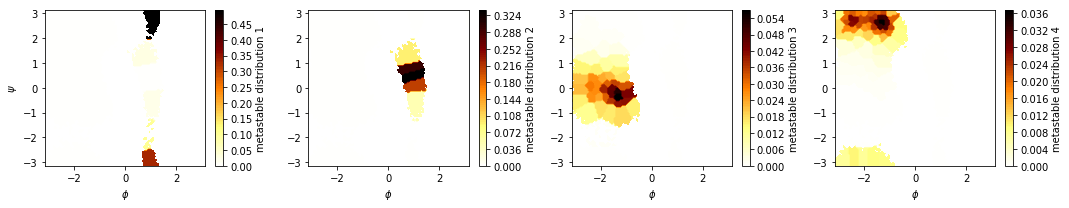

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *data_concatenated.T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('$\phi$')
axes[0].set_ylabel('$\psi$')
fig.tight_layout()

PCCA++ nicely separates the high-density regions and we find that each of the basins was assigned a metastable set.
This indicates that our projection indeed describes the slow dynamics.

We concatenate all three discrete trajectories and obtain a single trajectory of metastable states which we use to visualize the metastable state memberships of all datapoints.
We further compute the state with the highest membership to a PCCA metastable state to plot a state label there.

⚠️ Please remember that the concatenated discrete trajectories (dtrajs) are not meant to be used for MSM estimation (artificial transitions), but only for visualization and indexing purposes!

In [7]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[msm.active_set[highest_membership]]

## 2. Mean first passage times
<a id="mfpt"></a>

Now, we use the `mfpt()` method of the MSM object to compute MFPTs between pairs of metastable sets and compute the inverse MFPTs for visualization purposes:

In [8]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

We visualize our model in backbone torsion space:

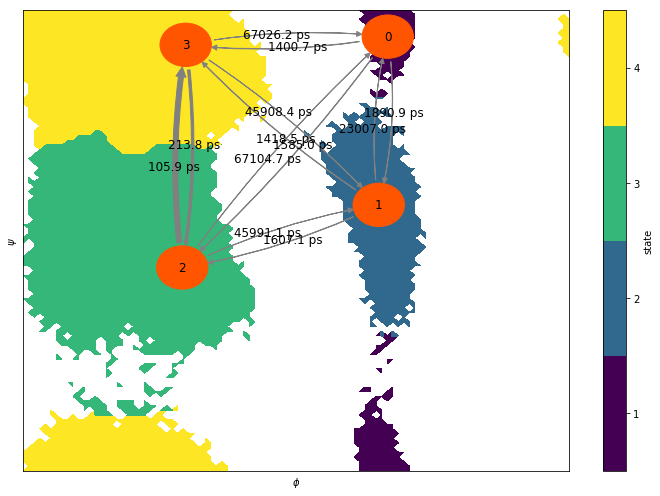

In [10]:
fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    *data_concatenated.T, metastable_traj, ax=ax, zorder=-1)
misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers,
    figpadding=0,
    arrow_label_format='%.1f ps',
    arrow_labels=mfpt,
    size=12,
    show_frame=True,
    ax=ax)

ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
fig.tight_layout()

Have you noticed how well the metastable state coloring agrees with the eigenvector visualization of the three slowest processes?

Now we define a small function to visualize samples of metastable states with NGLView.

In [11]:
def visualize_metastable(samples, cmap, selection='backbone'):
    """ visualize metastable states
    Parameters
    ----------
    samples: list of mdtraj.Trajectory objects
        each element contains all samples for one metastable state.
    cmap: matplotlib.colors.ListedColormap
        color map used to visualize metastable states before.
    selection: str
        which part of the molecule to selection for visualization. For details have a look here:
        http://mdtraj.org/latest/examples/atom-selection.html#Atom-Selection-Language
    """
    import nglview
    from matplotlib.colors import to_hex

    widget = nglview.NGLWidget()
    widget.clear_representations()
    ref = samples[0]
    for i, s in enumerate(samples):
        s = s.superpose(ref)
        s = s.atom_slice(s.top.select(selection))
        comp = widget.add_trajectory(s)
        comp.add_ball_and_stick()

    # this has to be done in a separate loop for whatever reason...
    x = np.linspace(0, 1, num=len(samples))
    for i, x_ in enumerate(x):
        c = to_hex(cmap(x_))
        widget.update_ball_and_stick(color=c, component=i, repr_index=i)
        widget.remove_cartoon(component=i)
    return widget

We now sample some representative structures and visualize these with the aid of NGLView.
For the sake of clarity, we draw only the backbone atoms.
Since we have obtained several samples for each metastable state, you can click the play button to iterate over all samples.
For each iteration, the samples of all four states will be drawn.
You can double click the molecule to show it at full screen.
Press escape to go back. 

In [12]:
cmap = mpl.cm.get_cmap('viridis', nstates)

my_samples = [pyemma.coordinates.save_traj(files, idist, outfile=None, top=pdb)
              for idist in msm.sample_by_distributions(msm.metastable_distributions, 50)]

visualize_metastable(my_samples, cmap, selection='backbone')

NGLWidget(count=50)

## 3. Transition path theory
<a id="tpt"></a>

Coming back to TPT, we now have more than two metastable states and can expect more insights from analyzing the transition paths.
As an example, we will focus on the committor between metastable sets $0$ and $3$ as defined above.

In [13]:
A = msm.metastable_sets[0]
B = msm.metastable_sets[3]
flux = pyemma.msm.tpt(msm, A, B)

Before we go on with the visualization, let's coarse grain the flux with the metastable sets estimated with PCCA++:

In [14]:
cg, cgflux = flux.coarse_grain(msm.metastable_sets)

We now show an overlay of the committor probabilities and the most likely transition path from the coarse graining TPT:

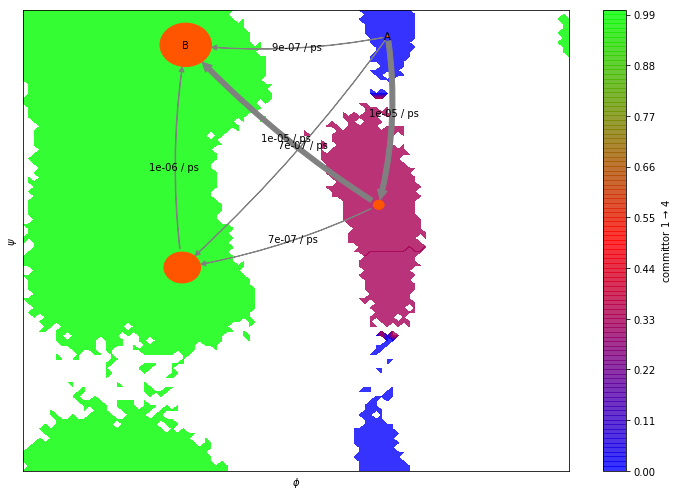

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))

pyemma.plots.plot_contour(
    *data_concatenated.T,
    flux.committor[dtrajs_concatenated],
    cmap='brg',
    ax=ax,
    mask=True,
    cbar_label=r'committor 1 $\to$ 4',
    alpha=0.8,
    zorder=-1);

pyemma.plots.plot_flux(
    cgflux,
    coarse_state_centers,
    cgflux.stationary_distribution,
    state_labels=['A','' ,'', 'B'], 
    ax=ax,
    show_committor=False,
    figpadding=0,
    show_frame=True,
    arrow_label_format='%2.e / ps');

ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
fig.tight_layout()

First, the color map shows us a region with committor probability $\approx 0.5$.
This indicates that this particular metastable state is a transition state in the pathway from $A$ to $B$.
Second, the `plot_flux()` function displays the most likely transition pathway along this path.
There are other, less likely pathways included in the plot as well.
The arrow thickness indicates the flux between the states.

We can decompose the flux into these individual pathways by:

In [17]:
paths, path_fluxes = cgflux.pathways(fraction=0.99)
print('percentage       \tpath')
print('-------------------------------------')
for i in range(len(paths)):
    print(np.round(path_fluxes[i] / np.sum(path_fluxes), 3),' \t', paths[i] + 1)

percentage       	path
-------------------------------------
0.842  	 [1 2 4]
0.064  	 [1 4]
0.049  	 [1 2 3 4]
0.046  	 [1 3 4]


As expected, about $85\%$ of the flux goes through only one pathway.
To get a cleaner picture, the `plot_flux()` function supports a `minflux` keyword argument that can be increased to exclude very low fluxes from the plot.

## 4. Exercises
<a id="exerc"></a>

#### Exercise 4.1

Define a `featurizer` that loads the heavy atom coordinates and load the data into memory.
Also load the TICA object from [Notebook 04 ➜ 📓](04-msm-analysis.ipynb) to transform the featurized data.
Further, the estimated MSM, Bayesian MSM, and Cluster objects should be loaded from disk. 

In [ ]:
feat = #FIXME
feat. #FIXME
data = #FIXME

tica = #FIXME
tica_output = tica.transform(data)
tica_concatenated = np.concatenate(tica_output)

msm = #FIXME
bayesian_msm = #FIXME

cluster = #FIXME
dtrajs_concatenated = #FIXME

###### Solution

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
pairs = feat.pairs(feat.select_Heavy())
feat.add_distances(pairs, periodic=False)
data = pyemma.coordinates.load(files, features=feat)

tica = pyemma.load('nb4_e.pyemma', model_name='ala2tica_tica')
tica_output = tica.transform(data)
tica_concatenated = np.concatenate(tica_output)

msm = pyemma.load('nb4_e.pyemma', model_name='ala2tica_msm')
bayesian_msm = pyemma.load('nb4_e.pyemma', model_name='ala2tica_bayesian_msm')

cluster = pyemma.load('nb4_e.pyemma', model_name='ala2tica_cluster')
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

#### Exercise 4.2

Do a PCCA++ analysis of the MSM with four metastable states,
compute the probability of the metastable sets, and visualize the metastable state memberships.

In [ ]:
nstates = 4
#FIXME (PCCA)

for i, s in enumerate(msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, )) #FIXME

    
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated.T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

###### Solution

π_1 = 0.001519
π_2 = 0.028352
π_3 = 0.327688
π_4 = 0.642441


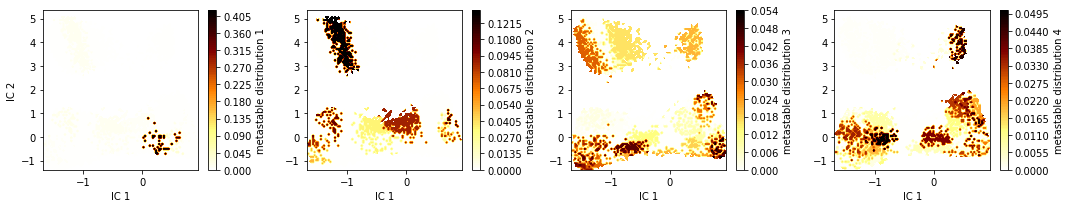

In [21]:
nstates = 4
msm.pcca(nstates)

for i, s in enumerate(msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, msm.pi[s].sum()))

fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated.T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

Did you guess the metastable states correctly?

Note the similarities between the MSM built from the backbone torsions and the MSM built from the TICA projection of heavy atom distances.
Even though we started from different features, both models found the same kinetic information in the data.

#### Exercise 4.3

Compute the pairwise MFPTs and transition rates, and visualize the resulting kinetic network.

In [ ]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = #FIXME

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=np.asarray([[0, 0], [4, 0], [2, 4], [6, 4]]),
    arrow_label_format='%.1f ps',
    arrow_labels=mfpt,
    arrow_scale=3.0,
    state_labels=range(1, nstates + 1),
    size=12);

###### Solution

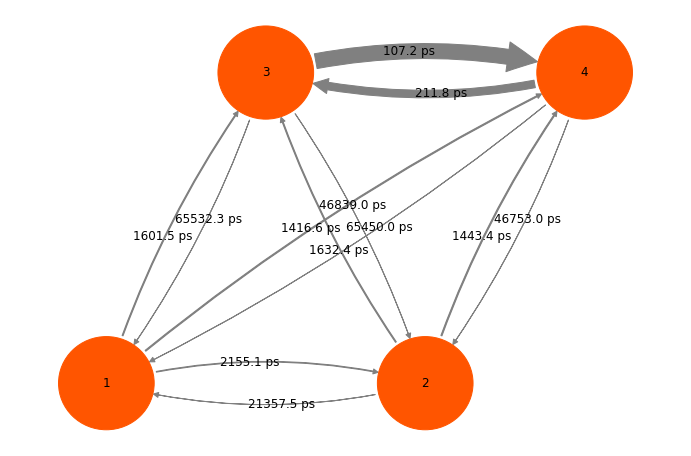

In [22]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=np.asarray([[0, 0], [4, 0], [2, 4], [6, 4]]),
    arrow_label_format='%.1f ps',
    arrow_labels=mfpt,
    arrow_scale=3.0,
    state_labels=range(1, nstates + 1),
    size=12);

## References

<a id="cite-pcca_plus_plus"/><sup><a href=#ref-1>[^]</a><a href=#ref-4>[^]</a></sup>Susanna Röblitz and Marcus Weber. 2013. _Fuzzy spectral clustering by PCCA+: application to Markov state models and data classification_. [URL](https://doi.org/10.1007/s11634-013-0134-6)

<a id="cite-weinan-tpt"/><sup><a href=#ref-2>[^]</a></sup>Weinan E. and Eric Vanden-Eijnden. 2006. _Towards a Theory of Transition Paths_. [URL](https://doi.org/10.1007/s10955-005-9003-9)

<a id="cite-metzner-msm-tpt"/><sup><a href=#ref-3>[^]</a></sup>Philipp Metzner and Christof Schütte and Eric Vanden-Eijnden. 2009. _Transition Path Theory for Markov Jump Processes_. [URL](https://doi.org/10.1137/070699500)



#### Disclaimer: 
This tutorial has been adapted from pyemma tutorials 05 (https://github.com/markovmodel/pyemma_tutorials)


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

Maintainers of the original notebooks [@cwehmeyer](https://github.com/cwehmeyer), [@marscher](https://github.com/marscher), [@thempel](https://github.com/thempel), [@psolsson](https://github.com/psolsson)